## Programming Lab #2
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that predict the likelihood a person has a stroke. The data include:
  
  - `age`: Patient age, numeric
  - `avg_glucose_level`: Blood sugar levels, numeric
  - `bmi`: Body mass index, numeric
  - `ever_married`: Ever married, dummy/character (Yes, No)
  - `gender`: Male, Female, or Other, character
  - `heart_disease`: Has heart disease, dummy
  - `hypertension`: Has hypertension, dummy
  - `id`: Study identification number
  - `Residence_type`: Type of residence, dummy/character (Urban, Rural)
  - `smoking_status`: Former, never, or current smoker, categorical
  - `work_type`: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (`Private`), Self-employed (`Self-employed`)
  - `stroke`: Suffered a stroke in the sample period
  
The data come in two files: `training_data.csv`, which you should use to build your models, and `testing_data.csv`, which you should use to test your models. The models must be trained on the training data and tested on the testing data, but providing both files allows you to experiment with your choices and iterate on model designs. If performance drops on the testing data, you know there's a problem.
  
You can use any of the tools presented in class: $k$ nearest neighbor, linear models, or decision trees. In principle, $k$ means clustering might also be helpful for looking for patterns in the data that the other methods might miss. Using canned versions of more advanced tools (boosting, bagging, random forests, neural networks, etc.) is deeply unsporting and thus not allowed. You can be creative about transforming variables, or combining decision trees with linear models or $k$NN. Try something interesting. Fail extravagantly. The goal is to work on an intellectually interesting question that is similar to the tasks that data scientists are called on to do every day.
  
We will compare the groups' models to see if there are common trends or significant differences, and also to declare **The Winners** on the basis of whichever team achieves the lowest $RMSE$ on the testing data. A simple linear model with some polynomials and dummy variables achieves an $R^2$ of .087 and a $RMSE$ of .206.

In [1]:
!git clone https://github.com/DS3001/Group4.git

Cloning into 'Group4'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 50 (delta 18), reused 34 (delta 11), pack-reused 0
Receiving objects: 100% (50/50), 946.97 KiB | 16.05 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [1]:
import pandas as pd
import numpy as np

In [51]:
try:
    df_train = pd.read_csv('./Group4/project_2/data/cleaned_training_data.csv')
    df_test = pd.read_csv('./Group4/project_2/data/cleaned_testing_data.csv')
except:
    df_train = pd.read_csv('data/cleaned_training_data.csv')
    df_test = pd.read_csv('data/cleaned_testing_data.csv')

In [52]:
df_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,log_avg_glucose_level,bmi_NA
0,36.0,0,0,65.87,32.2,0,0,1,0,1,...,0,0,0,1,0,1,0,0,4.187683,0
1,45.0,0,0,68.66,25.3,0,1,0,0,1,...,0,0,1,0,0,0,1,0,4.229167,0
2,58.0,0,0,170.93,30.7,0,0,1,1,0,...,1,0,1,0,1,0,0,0,5.141254,0
3,61.0,0,0,69.88,27.1,0,1,0,0,1,...,1,0,0,1,0,0,1,0,4.246779,0
4,78.0,0,0,103.86,30.6,0,1,0,1,0,...,0,0,0,1,1,0,0,0,4.643044,0


In [8]:
y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

### Decision Tree with Linear Models at Root Nodes

I would like to combine linear models with decision trees or another method. My idea is to implement the "linear tree" strategy, where you run a decision tree, but instead of having a fixed value as the output of each node, you fit a linear model on all the samples that comprise that node.

#### Decision Tree Creation

First, I'll train the decision tree. I've read that a good max depth is about log_2(number of attributes), which is log_2(22), which is about 4.4. So, I'll try a max depth of 4.

In [9]:
from sklearn import tree
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [10]:
dtr_model = tree.DecisionTreeRegressor(max_depth=4)
dtr = dtr_model.fit(X_train, y_train)

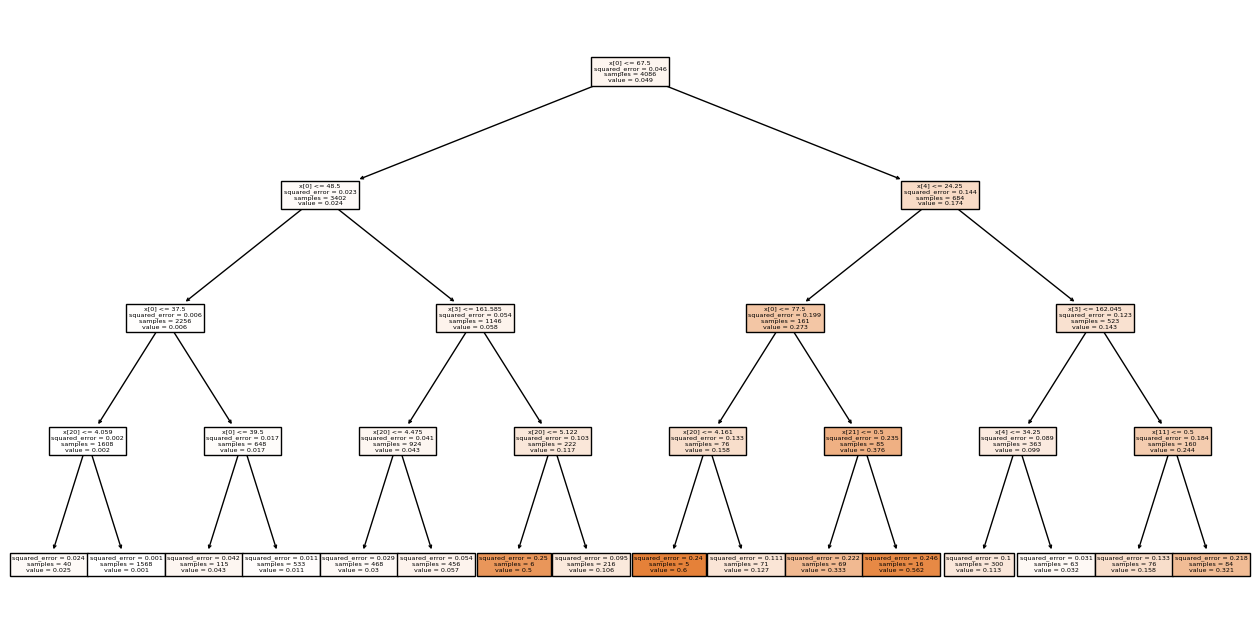

In [11]:
plt.figure(figsize=(16, 8))
tree.plot_tree(dtr,filled=True)
plt.show()

#### Linear Model Creation

Next, I'll train a linear model on the samples belonging to each leaf node. I can get the leaf node that each sample ends up at with the `.apply()` function. (I found this information [here](https://stackoverflow.com/questions/45398737/is-there-any-way-to-get-samples-under-each-leaf-of-a-decision-tree)).

In [12]:
training_leaf_nodes = dtr.apply(X_train)
leaf_node_values = np.unique(training_leaf_nodes)
print(leaf_node_values)

[ 4  5  7  8 11 12 14 15 19 20 22 23 26 27 29 30]


I'll make a list of DataFrames, where each DataFrame holds the samples that ended up at a particular leaf node; I'll call each of these groups a "subpopulation". I'll also make a corresponding list with the y values for each subpopulation.

In [13]:
def get_leaf_node_samples(leaf_node_value, samples, y, leaf_nodes_for_samples):
  indices_of_samples = (leaf_nodes_for_samples == leaf_node_value)
  node_samples = samples.loc[indices_of_samples].reset_index().drop("index", axis=1)
  node_y = y.loc[indices_of_samples].reset_index().drop("index", axis=1)["stroke"]
  return node_samples, node_y

In [14]:
subpopulation_dfs = list()
subpopulation_ys = list()
node_value_to_index = dict()

index = 0
for leaf_node_value in leaf_node_values:
  node_value_to_index[leaf_node_value] = index
  subpopulation, subpop_y = get_leaf_node_samples(leaf_node_value, X_train, y_train, training_leaf_nodes)
  subpopulation_dfs.append(subpopulation)
  subpopulation_ys.append(subpop_y)
  index += 1

Next I'll make the linear model for each subpopulation.

In [15]:
def train_linear_model(samples, y):
  reg = LinearRegression().fit(samples, y)
  return reg

In [16]:
def evaluate_linear_model(model, samples, y):
  print('R2: ', model.score(samples, y)) # R squared measure
  y_hat = model.predict(samples)
  N = len(y)
  print('RMSE: ', (np.sum( (y - y_hat)**2)/N )**.5, "\n" )   # R squared measure

In [17]:
linear_models = list()

for i in range(len(subpopulation_dfs)):
  model = train_linear_model(subpopulation_dfs[i], subpopulation_ys[i])
  evaluate_linear_model(model, subpopulation_dfs[i], subpopulation_ys[i])
  linear_models.append(model)

R2:  0.4314138324816541
RMSE:  0.11772547656841181 

R2:  0.017537291157841528
RMSE:  0.035377151042120615 

R2:  0.18961117110526415
RMSE:  0.18358205510322825 

R2:  0.018087700559798248
RMSE:  0.10454182414017002 

R2:  0.04003357625818538
RMSE:  0.16690683152781227 

R2:  0.04239691884109642
RMSE:  0.22690748724651538 

R2:  1.0
RMSE:  1.4503892858778862e-15 

R2:  0.07892223562767298
RMSE:  0.2960308488338074 

R2:  1.0
RMSE:  6.280369834735101e-16 

R2:  0.27518044655749585
RMSE:  0.28325246705268725 

R2:  0.13427512729084012
RMSE:  0.43861521296744826 

R2:  0.9725244053301213
RMSE:  0.08222877918217232 

R2:  0.01764009296839497
RMSE:  0.31419143137042765 

R2:  0.4353329269347396
RMSE:  0.13174544168347663 

R2:  0.20060495185504257
RMSE:  0.3260226285459082 

R2:  0.13894713114112234
RMSE:  0.4333660972003207 



#### Performance on Test Set

Finally, I'll examine how this combined model does on the test data.

The first step is to identify which leaf node each sample in the test set would be sorted into.

In [18]:
testing_leaf_nodes = dtr.apply(X_test)

Next, I will make a prediction for each test sample based on the linear model corresponding to that sample's leaf node. I'll concatenate all of these predictions into one full `y_hat` vector.

In [19]:
X_test.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,log_avg_glucose_level,bmi_NA
0,58.0,1,0,87.96,39.2,0,1,0,1,0,...,0,0,0,1,0,0,1,0,4.476882,0
1,8.0,0,0,110.89,17.6,1,0,1,0,0,...,0,0,0,1,1,0,0,0,4.708539,0
2,70.0,0,0,69.04,35.9,1,0,0,1,0,...,0,0,1,0,0,1,0,0,4.234686,0
3,47.0,0,0,210.95,50.1,1,0,0,1,0,...,0,0,0,1,1,0,0,0,5.351621,0
4,74.0,1,0,205.84,54.6,1,0,0,1,0,...,1,0,0,1,0,0,1,0,5.327099,0


In [20]:
print(type(X_test[0:1]))
print(type(X_test.iloc[0]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [21]:
test_y_hat = list()

for i in range(len(X_test)):
  sample_leaf_node = testing_leaf_nodes[i]
  sample_index = node_value_to_index[sample_leaf_node]
  node_model = linear_models[sample_index]
  sample_y = node_model.predict(X_test[i:i+1])
  test_y_hat.append(sample_y[0]) # there's only one prediction in each sample_y

In [22]:
y_hat = pd.Series(test_y_hat)

Finally, I'll calculate the performance of the combined models by comparing `y_hat` and `y_test`.

In [23]:
from sklearn.metrics import r2_score

In [24]:
final_r2 = r2_score(y_test, y_hat)
print('R2: ', final_r2)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5)

R2:  -2.696077024001074
RMSE:  0.4145112243796263


### Important Visualizations for Analysis

In [36]:
df_train.columns[0]

'age'

Let us visualize the distribution of the important features as seen in our training data.

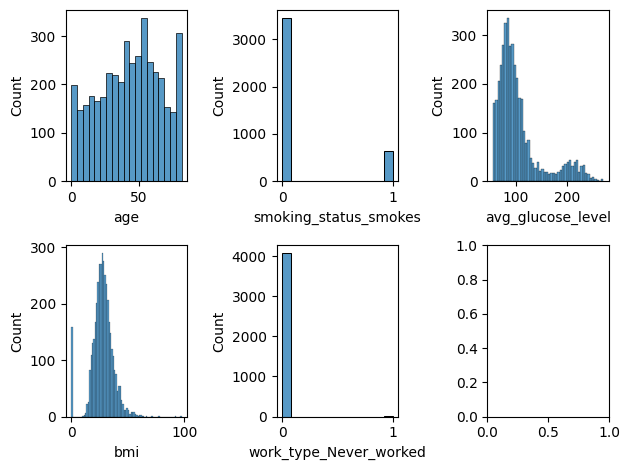

In [39]:
import seaborn as sns

fig, axs = plt.subplots(nrows = 2, ncols=3)

important_features = [0, 20, 3, 4, 11]
for ind, col_idx in enumerate(important_features):
    row = ind//3
    col = ind%3
    sns.histplot(df_train, x=df_train.columns[col_idx], ax=axs[row][col])

plt.tight_layout()

To get a better idea of how these features may be relevant for our model, we visualize the distribution of values for stroke patients and non-stroke patients separately.

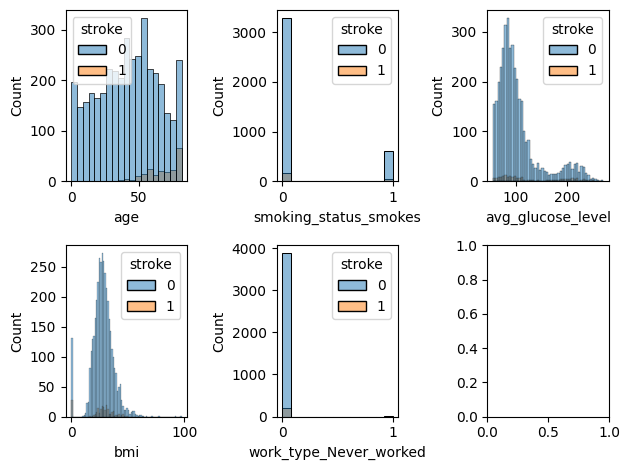

In [43]:
import seaborn as sns

fig, axs = plt.subplots(nrows = 2, ncols=3)

important_features = [0, 20, 3, 4, 11]
for ind, col_idx in enumerate(important_features):
    row = ind//3
    col = ind%3
    sns.histplot(df_train, x=df_train.columns[col_idx], ax=axs[row][col], hue="stroke")

plt.tight_layout()

The same information can also be presented as a kernel density plot, which emphasizes the shapes of our non-categorical features.

C:\Users\al146\AppData\Local\Temp\ipykernel_12912\1019388318.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_train, x=df_train.columns[col_idx], ax=axs[row][col], hue="stroke")


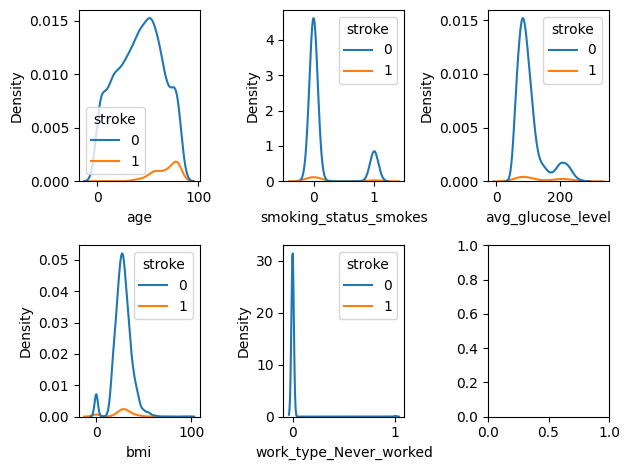

In [44]:
import seaborn as sns

fig, axs = plt.subplots(nrows = 2, ncols=3)

important_features = [0, 20, 3, 4, 11]
for ind, col_idx in enumerate(important_features):
    row = ind//3
    col = ind%3
    sns.kdeplot(df_train, x=df_train.columns[col_idx], ax=axs[row][col], hue="stroke")

plt.tight_layout()

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4086 entries, 0 to 4085
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4086 non-null   float64
 1   hypertension                    4086 non-null   int64  
 2   heart_disease                   4086 non-null   int64  
 3   avg_glucose_level               4086 non-null   float64
 4   bmi                             4086 non-null   float64
 5   stroke                          4086 non-null   int64  
 6   gender_Female                   4086 non-null   int64  
 7   gender_Male                     4086 non-null   int64  
 8   ever_married_No                 4086 non-null   int64  
 9   ever_married_Yes                4086 non-null   int64  
 10  work_type_Govt_job              4086 non-null   int64  
 11  work_type_Never_worked          4086 non-null   int64  
 12  work_type_Private               40

In [50]:
df_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,log_avg_glucose_level,bmi_NA
count,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,...,4086.00000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000
mean,43.328409,0.097895,0.056045,106.001263,27.799462,0.048703,0.586882,0.413118,0.342633,0.657367,...,0.16324,0.132648,0.497797,0.502203,0.303720,0.170827,0.368331,0.157122,4.591664,0.038913
std,22.532146,0.297209,0.230037,45.049641,9.509059,0.215273,0.492454,0.492454,0.474648,0.474648,...,0.36963,0.339235,0.500056,0.500056,0.459919,0.376404,0.482411,0.363960,0.360563,0.193412
min,0.080000,0.000000,0.000000,55.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.009513,0.000000
25%,26.000000,0.000000,0.000000,77.292500,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.347597,0.000000
50%,45.000000,0.000000,0.000000,91.990000,27.700000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.521680,0.000000
75%,61.000000,0.000000,0.000000,113.830000,32.800000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,4.734706,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.604846,1.000000


In [59]:
categorical_vars = [c for c in df_train.columns if df_train[c].dtype=='int64']
print("Number of entries for each categorical class")
for col in categorical_vars:
    print(f'{col}: {df_train[col].sum()}')

Number of entries for each categorical class
hypertension: 400
heart_disease: 229
stroke: 199
gender_Female: 2398
gender_Male: 1688
ever_married_No: 1400
ever_married_Yes: 2686
work_type_Govt_job: 534
work_type_Never_worked: 15
work_type_Private: 2328
work_type_Self-employed: 667
work_type_children: 542
Residence_type_Rural: 2034
Residence_type_Urban: 2052
smoking_status_Unknown: 1241
smoking_status_formerly smoked: 698
smoking_status_never smoked: 1505
smoking_status_smokes: 642
bmi_NA: 159


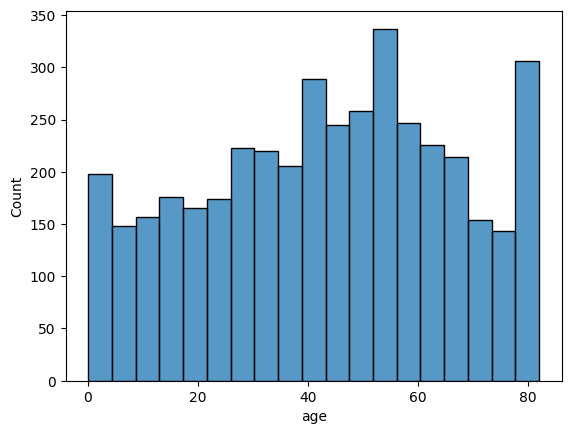

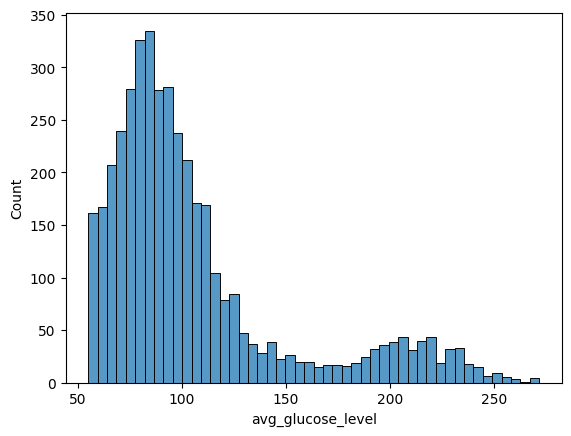

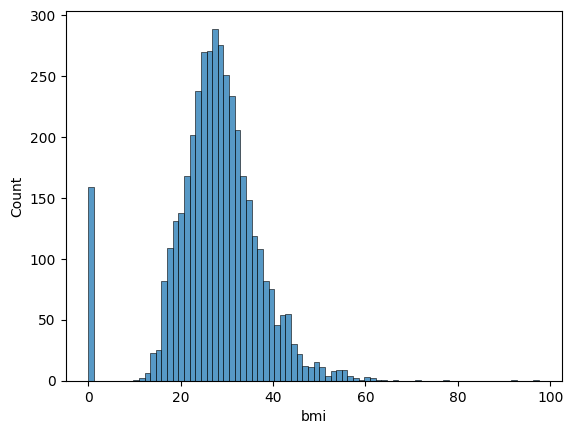

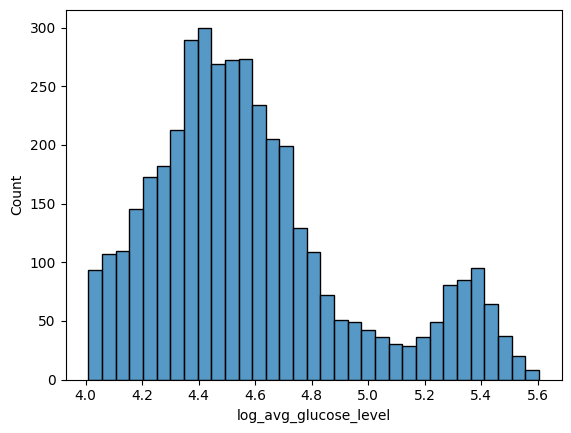

In [62]:
numerical_vars = [c for c in df_train.columns if df_train[c].dtype=='float64']
for col in numerical_vars:
    sns.histplot(df_train, x=col)
    plt.show()

Here, we visualize the outputs for the model.

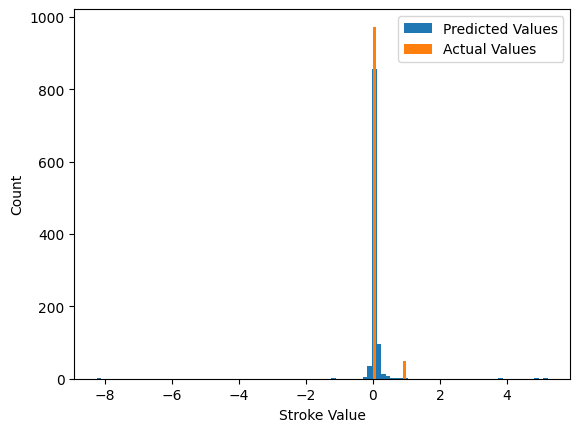

In [40]:
plt.hist(y_hat, bins=100, label="Predicted Values")
plt.hist(y_test, label="Actual Values")
plt.xlabel("Stroke Value")
plt.ylabel("Count")
plt.legend()

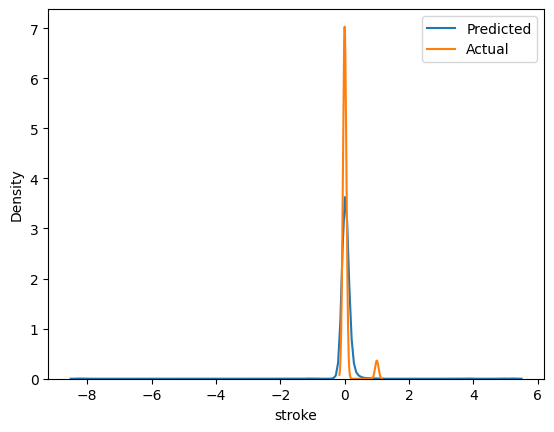

In [49]:
import seaborn as sns
sns.kdeplot(data=y_hat, label="Predicted")
sns.kdeplot(data=y_test, label="Actual")
plt.legend()

Text(0.5, 0, 'Predicted Stroke Value')

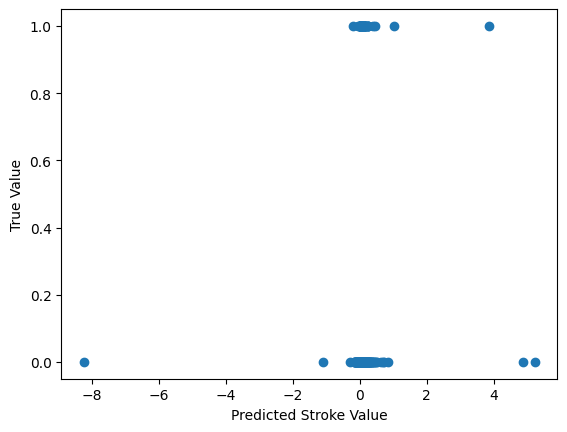

In [50]:
plt.scatter(y_hat, y_test)
plt.ylabel("True Value")
plt.xlabel("Predicted Stroke Value")